# MNEflow basic calssification example

# 1. Importing data

### 1.1.from MNE epochs

If you use MNE-python, all you need is to provide your epochs file (or list of epoch files) to mneflow.produce_tfrecords


In [1]:
#%pylab inline
#get epochs using your mne-python pipeline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=PendingDeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import sys
import os
from time import time, strftime, gmtime
import gc

import numpy as np
import mne
from mne.datasets import multimodal

os.chdir('/u/20/vranoug1/unix/OPM-BCI/mneflow-dev/mneflow/')
import mneflow
from mneflow import keras_models

from mneflow.keras_utils import plot_output, plot_history

# Force enable eager execution after importing mneflow
tf.compat.v1.enable_eager_execution()
mne.set_log_level(verbose='CRITICAL')

fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)

cond = raw.acqparser.get_condition(raw, None)
# get the list of condition names
condition_names = [k for c in cond for k,v in c['event_id'].items()]

epochs_list = [mne.Epochs(raw, **c) for c in cond]

epochs = mne.concatenate_epochs(epochs_list)

epochs = epochs.pick_types(meg='grad')
# print(epochs.info)

In [2]:
sys.path
print('---------\n'+mneflow.__file__)
print('tf version: '+tf.__version__)
print('executing eagerly: '+str(tf.executing_eagerly())+'\n---------')

---------
/u/20/vranoug1/unix/.conda/envs/py3ml/lib/python3.7/site-packages/mneflow/__init__.py
tf version: 1.14.0
executing eagerly: True
---------


### Convert epochs to TFRecord format

In [3]:
#Specify import options
import_opt = dict(savepath='../tfr/',  # path where TFR files will be saved
                  out_name='mne_sample_epochs',  # name of TFRecords files
                  fs=600,
                  input_type='trials',
                  target_type='int',
                  picks = {'meg':'grad'},
                  scale=True,  # apply baseline_scaling
                  crop_baseline=True,  # remove baseline interval after scaling
                  decimate=None,
                  scale_interval=(0, 60),  # indices in time axis corresponding to baseline interval
                  val_size=0.2,  # validation set size set to 15% of all data
                  overwrite=False,
                  segment=False,
                  test_set='holdout')


#write TFRecord files and metadata file to disk
#meta = mneflow.produce_tfrecords([epochs],**import_opt)  
meta = mneflow.produce_tfrecords([epochs], **import_opt)  

Metadata file found, restoring


# 2. Initialize the dataset object using the generated metadata file

The dataset object includes several methods that allow experimenting with the dataset without the need to repeat the preprocessing or overwriting the TFRecord files each time.

For example, you can train the model using any subset of classes, channels or reduce the sampling rate by decimating across the time domain.

In [4]:
dataset = mneflow.Dataset(meta, train_batch=200, class_subset=None, pick_channels=None, decim=None)

# 3. Choose from already implemented models

MNEflow pipeline consists of three major parts:
1. dataset
2. computational graph
3. optimizer

Each part has its own set of hyper-parameters and methods that can be tuned. See help for mneflow.Dataset
and mneflow.keras_models.Model for more details.
In this example will we use LF-CNN network


In [5]:
# specify model parameters
graph_specs = dict(n_ls=64,  # number of latent factors
                   filter_length=17,  # convolutional filter length
                   pooling=5,  # convlayer pooling factor
                   stride=5,  # stride parameter for pooling layer
                   padding='SAME',
                   dropout=.5,
                   nonlin=tf.nn.relu,
                   pool_type='max',
                   y_shape=meta['y_shape'],
                   model_path = import_opt['savepath'],  # not used at the moment
                   # regularization parameters
                   l1=3e-4,
                   l2=0)


In [6]:
model = keras_models.LFCNN(graph_specs, dataset)

#specify optimizer parameters
optim = tf.keras.optimizers.Adam(learning_rate=3e-4)
loss_f = tf.compat.v1.losses.softmax_cross_entropy

# % builtin
model.compile(loss=loss_f, optimizer=optim, metrics=['accuracy'])
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=1)

#train the model
history = model.fit(dataset.train, validation_data=dataset.val, epochs=10, steps_per_epoch=200,
                    validation_steps=1, callbacks=[stop_early], verbose=1)

model.summary()

de-mix init : OK
fc init : OK
Epoch 1/10
[None, 204, 302]
input x0 (?, 204, 302, 1)
de-mix built : OK
dmx (?, 302, 1, 64)
conv build : OK
fc ::: 3904 8
fc build : OK
200/200 [==============================] - 46s 228ms/step - loss: 1.7299 - acc: 0.3670 - val_loss: 1.0752 - val_acc: 0.8404
Epoch 2/10
200/200 [==============================] - 42s 212ms/step - loss: 0.7204 - acc: 0.9179 - val_loss: 0.8069 - val_acc: 0.9043
Epoch 3/10
200/200 [==============================] - 43s 216ms/step - loss: 0.5569 - acc: 0.9833 - val_loss: 0.7493 - val_acc: 0.9255
Epoch 4/10
200/200 [==============================] - 43s 213ms/step - loss: 0.4904 - acc: 0.9954 - val_loss: 0.7201 - val_acc: 0.9149
Epoch 5/10
200/200 [==============================] - 43s 214ms/step - loss: 0.4447 - acc: 0.9974 - val_loss: 0.6931 - val_acc: 0.9255
Epoch 6/10
200/200 [==============================] - 43s 213ms/step - loss: 0.4022 - acc: 0.9991 - val_loss: 0.6519 - val_acc: 0.9149
Epoch 7/10
200/200 [===============

# 4. Explore the trained model parameters
LFCNN allows to interpret the trained parameters in terms of toporaphies and the spectral properties of the latent sources contributing to each class. 

[752, 204, 302]
input x0 (752, 204, 302, 1)
dmx (752, 302, 1, 64)
out_w: (3904, 8)
demx: (204, 64) kern: (17, 64) tc_out: (752, 61, 64) out_w: (61, 64, 8)
Maximum spearman r * weight: 0.045727053889123126
Maximum spearman r * weight: 0.11395951057642013
Maximum spearman r * weight: 0.05764257194548807
Maximum spearman r * weight: 0.039221520361221174
Maximum spearman r * weight: 0.05411874376328215
Maximum spearman r * weight: 0.05629595004007088
Maximum spearman r * weight: 0.044350257221817485
Maximum spearman r * weight: 0.05231262607318817


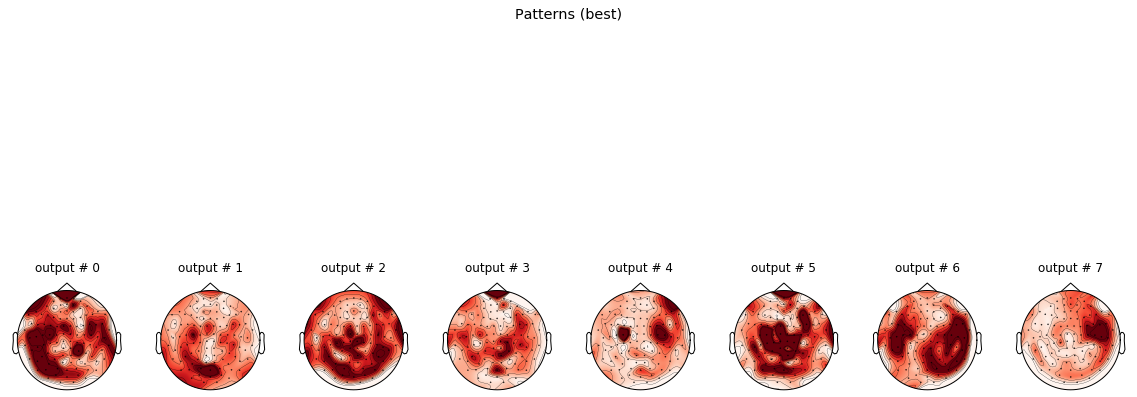

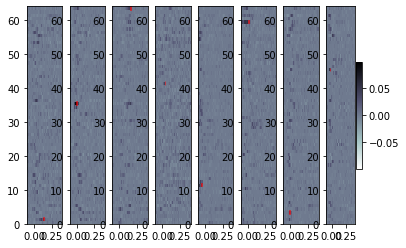

In [7]:
model.compute_patterns(data_path=meta['train_paths'], output='patterns')
f = model.plot_patterns(sensor_layout='Vectorview-grad', sorting='best', scale=False)

Maximum spearman r * weight: 0.045727053889123126
Maximum spearman r * weight: 0.11395951057642013
Maximum spearman r * weight: 0.05764257194548807
Maximum spearman r * weight: 0.039221520361221174
Maximum spearman r * weight: 0.05411874376328215
Maximum spearman r * weight: 0.05629595004007088
Maximum spearman r * weight: 0.044350257221817485
Maximum spearman r * weight: 0.05231262607318817


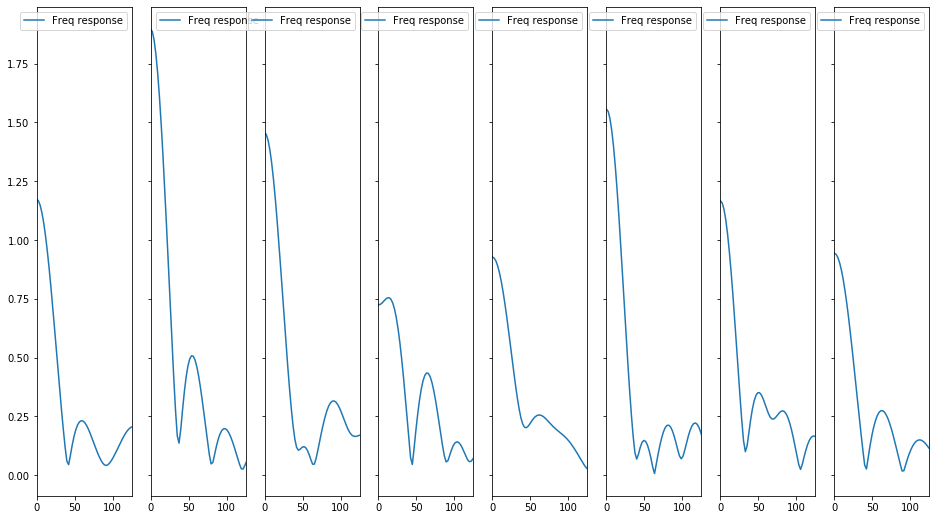

In [8]:
f3 = model.plot_spectra(sorting='best')

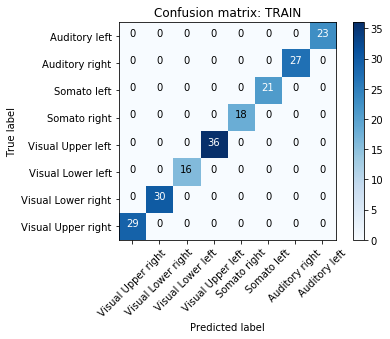

In [9]:
# Plotting the confusion matrix allows to identify analyze whether certain classes 
# are systematically harder to classify 
f2 = model.plot_cm(dataset, dset='train', steps=1, class_names=condition_names)

1/1 [==============================] - 0s 60ms/step - loss: 0.5497 - acc: 0.8830


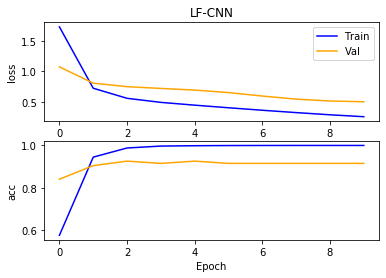

In [10]:
results = model.evaluate(dataset.test, steps=1, verbose=1)
model.plot_history()

# 5. LFLSTM

In [11]:
# specify model parameters
graph_specs = dict(n_ls=64,  # number of latent factors
                   filter_length=17,  # convolutional filter length
                   pooling=5,  # convlayer pooling factor
                   stride=5,  # stride parameter for pooling layer
                   padding='SAME',
                   dropout=.5,
                   nonlin=tf.nn.relu,
                   pool_type='max',
                   y_shape=meta['y_shape'],
                   model_path = import_opt['savepath'],  # not used at the moment
                   # regularization parameters
                   l1=3e-4,
                   l2=0,
                   # LSTM parameters
                   rnn_units=np.prod(meta['y_shape']),
                   rnn_dropout=0.0,
                   rnn_nonlin='tanh',
                   rnn_rec_nonlin='tanh',
                   rnn_forget_bias=True,
                   rnn_seq=True,
                   unroll=False)

model = keras_models.LFLSTM(graph_specs, dataset)

#specify optimizer parmeters
optim = tf.keras.optimizers.Adam(learning_rate=3e-4)
loss_f = tf.compat.v1.losses.softmax_cross_entropy

# % builtin
model.compile(loss=loss_f, optimizer=optim, metrics=['accuracy'])
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=1)

#train the model
history = model.fit(dataset.train, validation_data=dataset.val, epochs=10, steps_per_epoch=200,
                    validation_steps=1, callbacks=[stop_early], verbose=1)

model.summary()

de-mix init : OK
fc init : OK
de-mix init : OK
lstm init : OK
fc init : OK
Epoch 1/10
[None, 204, 302]
input x0 (?, 204, 302, 1)
input x0 (?, 204, 302, 1)
de-mix built : OK
dmx (?, 302, 1, 64)
demix dmx (?, 302, 1, 64)
dmx-sqout: (?, 302, 64, 1)
conv build : OK
features (?, 61, 64, 1)
flat features: (?, 1, 3904)
lstm_out (?, 1, 64)
fc ::: 64 8
fc build : OK
200/200 [==============================] - 227s 1s/step - loss: 6.4456 - acc: 0.1936 - val_loss: 5.0083 - val_acc: 0.4149
Epoch 2/10
200/200 [==============================] - 222s 1s/step - loss: 4.3069 - acc: 0.4599 - val_loss: 3.6306 - val_acc: 0.6809
Epoch 3/10
200/200 [==============================] - 191s 953ms/step - loss: 3.0020 - acc: 0.7126 - val_loss: 2.6373 - val_acc: 0.8830
Epoch 4/10
200/200 [==============================] - 129s 644ms/step - loss: 2.1620 - acc: 0.8880 - val_loss: 2.0206 - val_acc: 0.9255
Epoch 5/10
200/200 [==============================] - 127s 636ms/step - loss: 1.6613 - acc: 0.9512 - val_loss: 1.

In [ ]:
model.compute_patterns(data_path=meta['train_paths'], output='patterns')
f = model.plot_patterns(sensor_layout='Vectorview-grad', sorting='best', scale=False)

In [ ]:
f3 = model.plot_spectra(sorting='best')

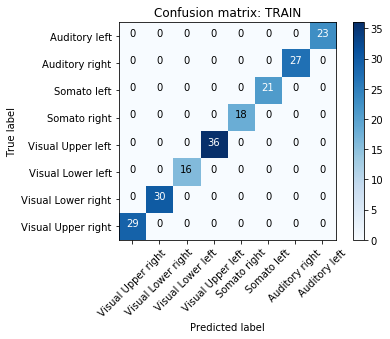

In [14]:
#Plotting the confusion matrix allows to identify analyze whether cetrain classes 
#are systematically harder to classify 
f2 = model.plot_cm(dataset, dset='train', steps=1, class_names=condition_names)

1/1 [==============================] - 0s 321ms/step - loss: 0.8612 - acc: 0.9149


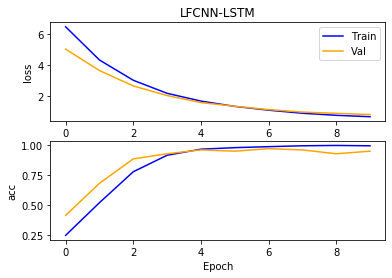

In [13]:
results = model.evaluate(dataset.test, steps=1, verbose=1)
model.plot_history()